In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
#if i want to speed up and use one file
#files2 = "CSVLog_20190518_122417.csv"

#i aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set
files = "aggregate_no_time_column.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

In [3]:
dataset.tail()

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG),Total fuel economy (MPG)
6633,18.03922,11.76471,59.0,29.8254,29.01961,885.903,183.2,658.75,67.05882,424.9606,0.994239,5.0,71.6,11.51674,-0.78125,0.308259,0.0,0.205909,0.0,30.11613
6634,17.64706,11.76471,59.0,29.8254,29.01961,885.903,183.2,640.00,67.05882,449.6170,0.994239,4.5,71.6,11.51674,-0.78125,0.257985,0.0,0.172327,0.0,30.11534
6635,17.64706,11.37255,59.0,29.8254,29.41176,885.903,183.2,607.75,67.05882,429.3117,0.994239,4.0,71.6,11.51674,-0.78125,0.325458,0.0,0.217398,0.0,30.11455
6636,17.25490,11.37255,59.0,29.8254,29.41176,885.903,183.2,606.75,67.05882,449.6170,0.994239,6.5,71.6,11.51674,-0.78125,0.239463,0.0,0.159955,0.0,30.11384
6637,17.64706,11.37255,59.0,29.8254,29.80392,885.903,183.2,604.50,67.05882,429.3117,0.994239,6.0,71.6,11.51674,-0.78125,0.227556,0.0,0.152002,0.0,30.11316


In [4]:
%%time 
#set seed here!

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Total fuel economy (MPG)")
validate_labels = validate.pop("Total fuel economy (MPG)")
test_labels = test.pop("Total fuel economy (MPG)")
dataset.tail()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.53 ms


In [5]:
#test_labels
#train.dtypes

In [6]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats
# training stats is a pandas data frame type
# use these values to normalize


,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,34.627982,21.190849,67.476394,29.719724,42.386819,1846.602014,185.468056,1519.243031,74.600704,922.530713,0.981198,21.357609,73.215319,17.530215,5.343577,1.481863,31.698669,1.001720,61.580652
std,24.269883,13.629759,12.327791,0.693420,26.238864,1171.830979,8.170581,641.823157,10.910486,569.909484,0.038568,15.251902,13.840881,8.851475,3.917435,1.561447,22.562794,1.051477,75.200068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,-2.343750,0.000000,0.000000,0.000000,0.000000
25%,15.686270,12.156860,62.600000,29.530100,19.607840,885.903000,183.200000,1092.437500,67.450980,478.624500,0.990457,5.000000,64.400000,10.040230,2.343750,0.312559,11.806050,0.210115,11.808668
50%,25.098040,15.294120,62.600000,29.825400,38.039220,1218.116500,185.000000,1486.875000,74.509800,617.860800,0.993141,24.000000,68.000000,15.060350,6.250000,0.822244,31.689930,0.560518,33.176370
75%,49.411770,26.666670,65.750000,29.825400,56.470590,2575.025000,188.600000,1987.687500,81.176470,1271.981000,0.995581,35.500000,77.000000,27.167690,7.812500,2.180635,46.602840,1.478460,85.786650
max,99.215680,90.980390,118.400000,30.120700,100.000000,5906.020000,204.800000,4719.500000,93.333340,2987.777000,1.016260,48.500000,122.000000,30.711300,12.500000,11.959920,76.428660,8.026347,782.499000


In [7]:
# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean
def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var
# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [8]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# These things are buggy, change
# scaler = StandardScaler()
# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)

# Fixes to make: normalize each data set by finding mean and STD of the training set
# and use these numbers to normalize all three sets
# TODO: Create mean and STD

#not technically correct
#from tf regression website
#Note: Although we intentionally generate these statistics from only the training dataset, 
#these statistics will also be used to normalize the test dataset. We need to do that to project the test 
#dataset into the same distribution that the model has been trained on.

#I normalize it according to the mean and sd of each predictor from each set instead of normalizaing from 
#training set only

In [9]:
#debugging
#normed_train

In [10]:
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [15]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5)                 100       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________
CPU times: user 328 ms, sys: 15.6 ms, total: 344 ms
Wall time: 319 ms


In [ ]:
%%time
# Also buggy: 

#change batch size?
#try early stop?
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))


In [22]:
%%time
numEpochs = 1000
history_object_B = model_B.fit(normed_train, train_labels, epochs=numEpochs, verbose=0,
         validation_data=(normed_validate, validate_labels))

CPU times: user 4min 12s, sys: 1min 46s, total: 5min 58s
Wall time: 2min 37s


In [23]:
# For these plots, our error is super low. There might be bugs because of
# the way we normalize
# TODO: Fix normalization

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()

# plot_history(history_object_A)

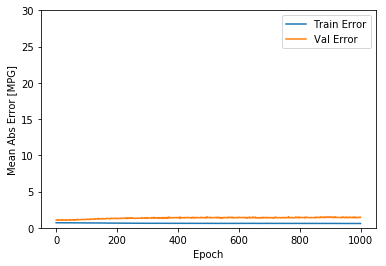

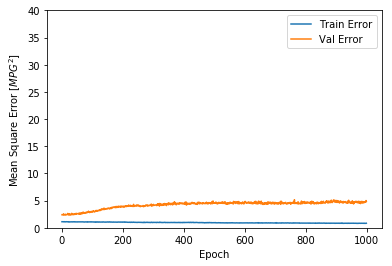

In [24]:
plot_history(history_object_B)

In [25]:
# Range of how wrong we allow a prediction to be, random number for now. unsure what is considered "good"
def accuracy(errorVec, epsilon):
    numExamples = len(errorVec)
    numCorrect = 0
    for error in errorVec:
        if abs(error) <= epsilon:
            numCorrect += 1
    print((numCorrect / float(numExamples))*100,"%")

epsilon = 1
test_predictions_B = model_B.predict(normed_test).flatten()
errorVec = test_predictions_B - test_labels
accuracy(errorVec, epsilon)



99.54853273137697 %
